In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import r2_score, mean_squared_error

### Loading the Dataset

In [2]:
df = pd.read_csv("/kaggle/input/binary-azeotropic-vle-dataset/ethanol_water_vle_500.csv")

In [3]:
df

,x1_mol,T_K,P_atm,y1_mol
0,0.360,305.485078,0.1,0.650476
1,0.420,304.856665,0.1,0.678961
2,0.440,304.676198,0.1,0.687613
3,0.540,303.927493,0.1,0.727510
4,0.560,303.801544,0.1,0.735187
...,...,...,...,...
495,0.986,361.922121,1.5,0.982895
496,0.988,361.934032,1.5,0.985271
497,0.994,361.971756,1.5,0.992532
498,0.996,361.985008,1.5,0.994998


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1_mol  500 non-null    float64
 1   T_K     500 non-null    float64
 2   P_atm   500 non-null    float64
 3   y1_mol  500 non-null    float64
dtypes: float64(4)
memory usage: 15.8 KB


In [5]:
df.isnull().sum()

x1_mol    0
T_K       0
P_atm     0
y1_mol    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

,x1_mol,T_K,P_atm,y1_mol
count,500.000000,500.000000,500.000000,500.000000
mean,0.825098,337.972125,0.738200,0.862997
std,0.168709,20.408680,0.475324,0.098948
min,0.080000,302.477730,0.100000,0.332692
25%,0.808250,315.611490,0.200000,0.837312
50%,0.866000,345.719353,0.800000,0.874859
75%,0.925000,355.806444,1.200000,0.920647
max,0.998000,368.202383,1.500000,0.997647


# Univariate Analysis

### x1_mol

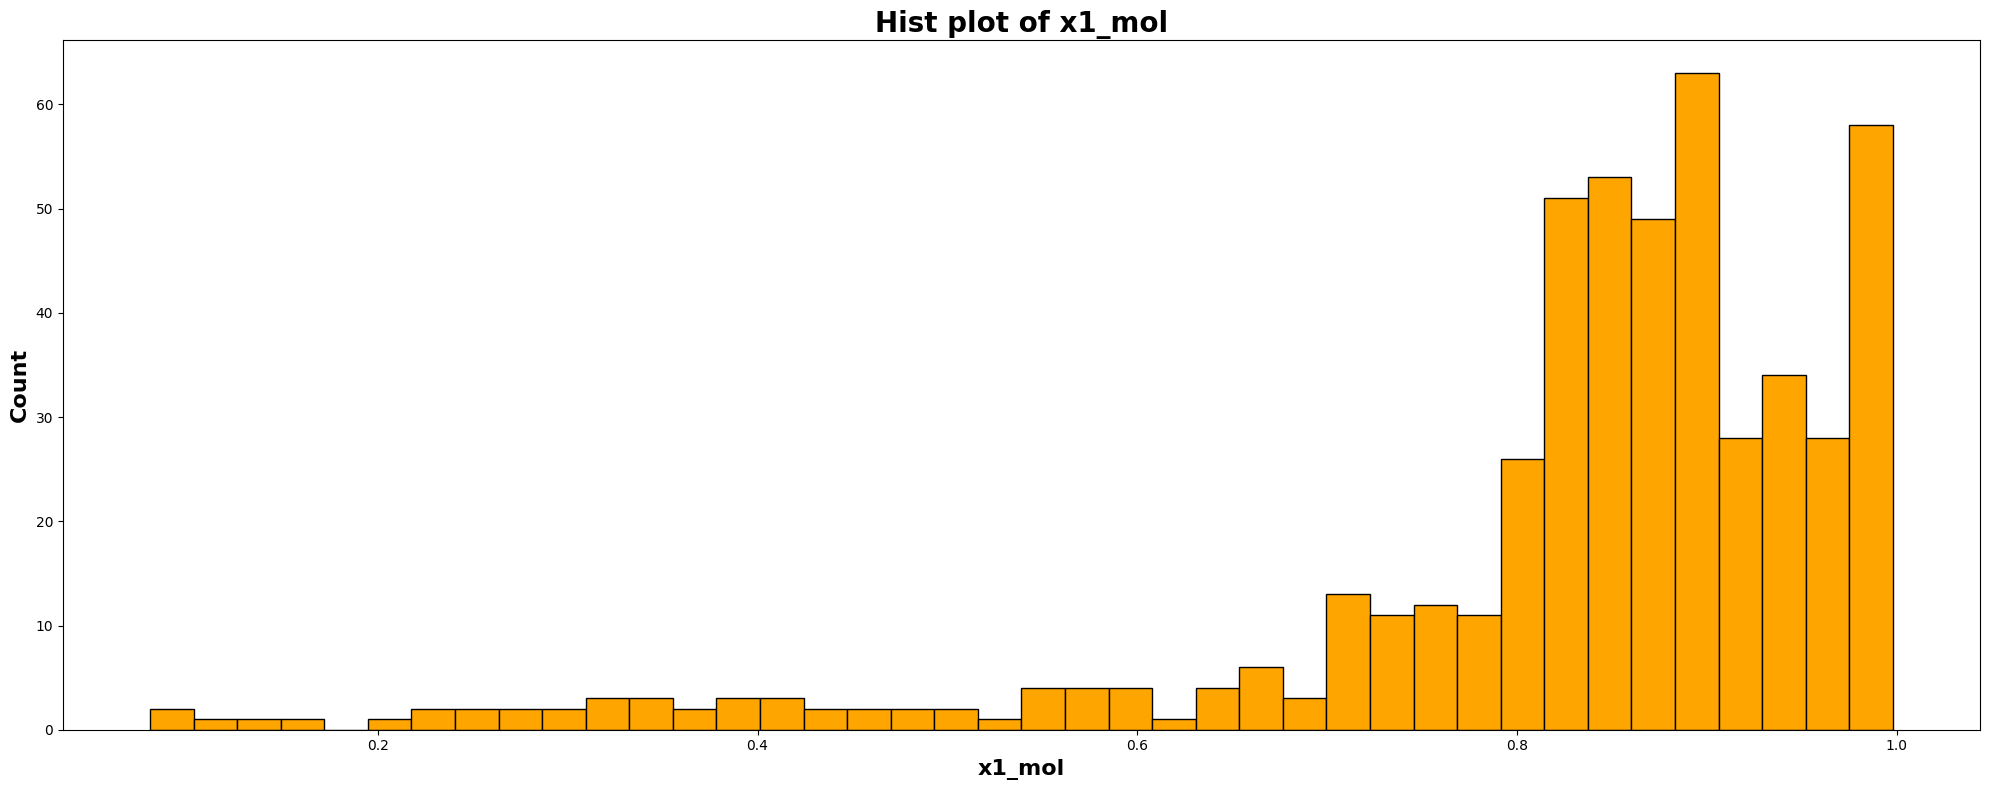

In [8]:
plt.figure(figsize = (20, 8), dpi = 100, facecolor = "white", edgecolor = "black")
plt.hist(
    df["x1_mol"],
    bins = 40,
    color = "orange",
    edgecolor = "black"
)
plt.title("Hist plot of x1_mol", fontsize = 20, color = "black", loc = "center", fontweight = "bold")
plt.xlabel("x1_mol", fontsize = 16, fontweight = "bold")
plt.ylabel("Count", fontsize = 16, fontweight = "bold")
plt.tight_layout()
plt.show()

### T_K

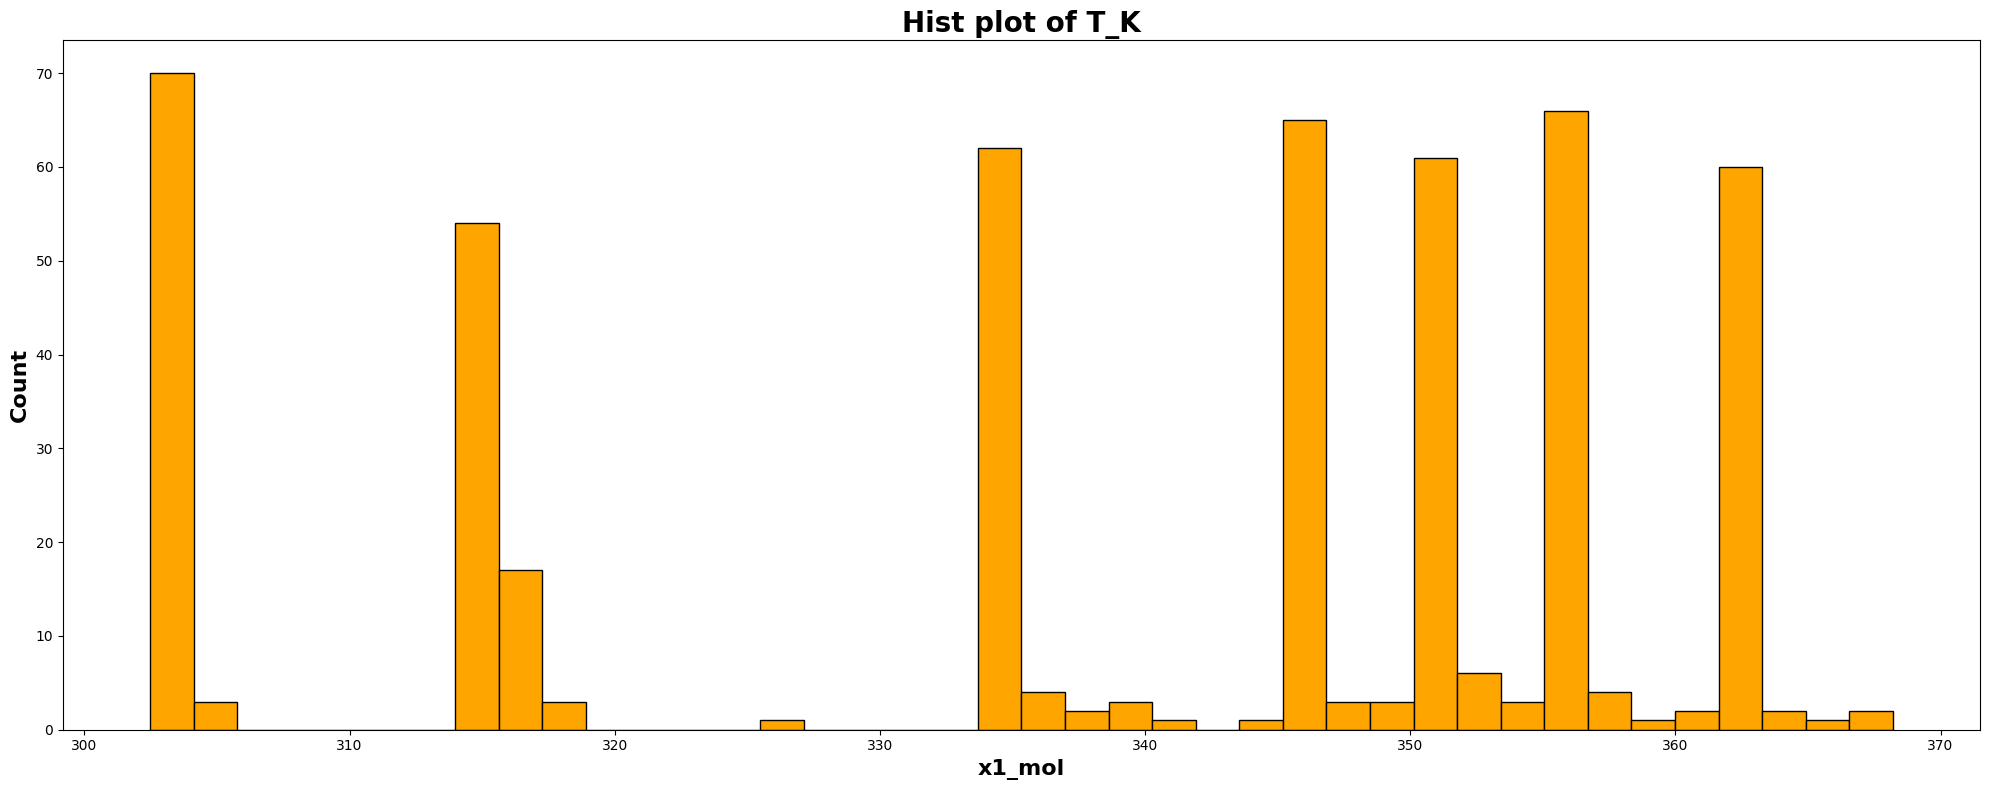

In [9]:
plt.figure(figsize = (20, 8), dpi = 100, facecolor = "white", edgecolor = "black")
plt.hist(
    df["T_K"],
    bins = 40,
    color = "orange",
    edgecolor = "black"
)
plt.title("Hist plot of T_K", fontsize = 20, color = "black", loc = "center", fontweight = "bold")
plt.xlabel("x1_mol", fontsize = 16, fontweight = "bold")
plt.ylabel("Count", fontsize = 16, fontweight = "bold")
plt.tight_layout()
plt.show()

### P_atm

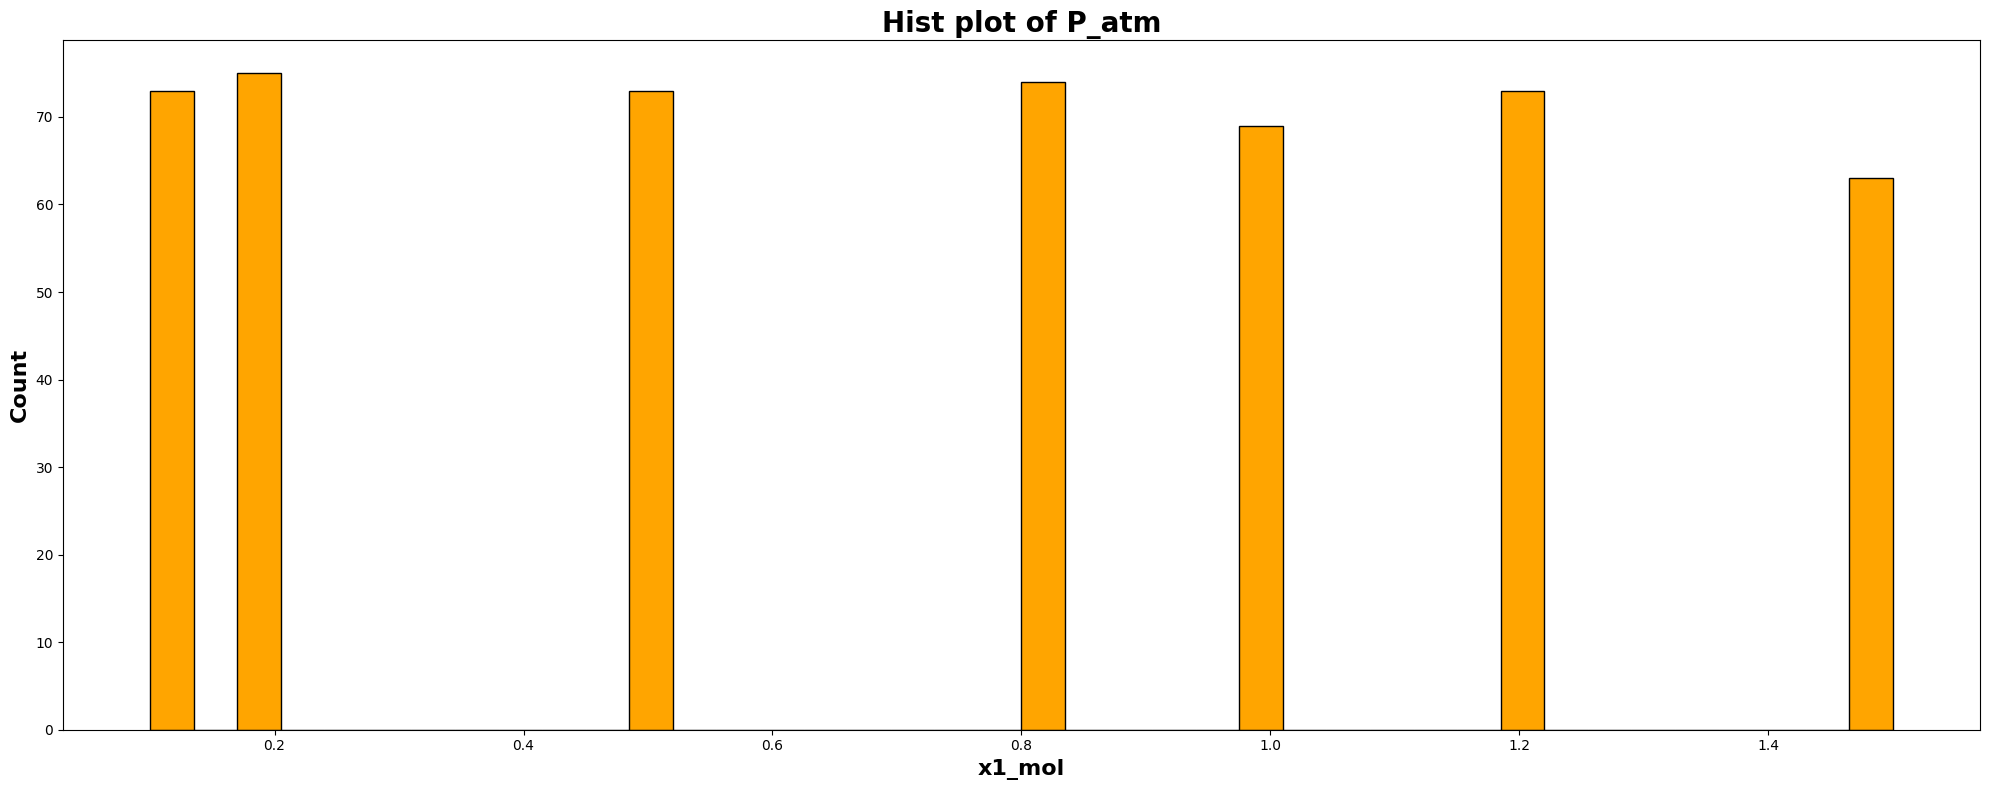

In [10]:
plt.figure(figsize = (20, 8), dpi = 100, facecolor = "white", edgecolor = "black")
plt.hist(
    df["P_atm"],
    bins = 40,
    color = "orange",
    edgecolor = "black"
)
plt.title("Hist plot of P_atm", fontsize = 20, color = "black", loc = "center", fontweight = "bold")
plt.xlabel("x1_mol", fontsize = 16, fontweight = "bold")
plt.ylabel("Count", fontsize = 16, fontweight = "bold")
plt.tight_layout()
plt.show()

### y1_mol

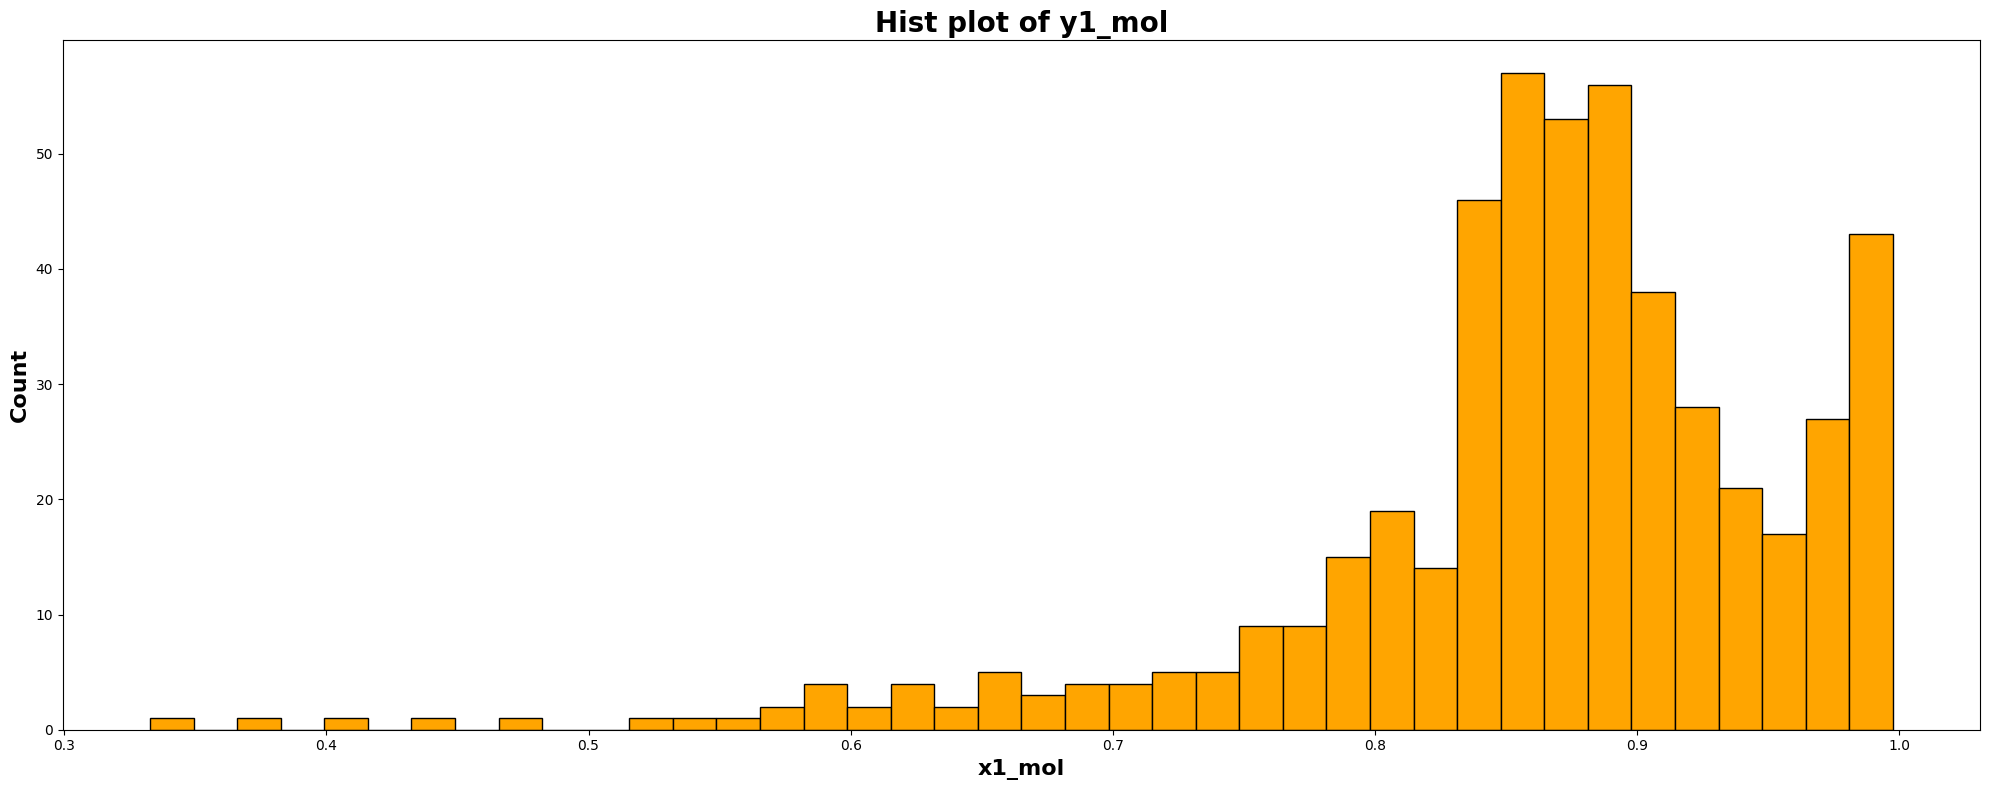

In [11]:
plt.figure(figsize = (20, 8), dpi = 100, facecolor = "white", edgecolor = "black")
plt.hist(
    df["y1_mol"],
    bins = 40,
    color = "orange",
    edgecolor = "black"
)
plt.title("Hist plot of y1_mol", fontsize = 20, color = "black", loc = "center", fontweight = "bold")
plt.xlabel("x1_mol", fontsize = 16, fontweight = "bold")
plt.ylabel("Count", fontsize = 16, fontweight = "bold")
plt.tight_layout()
plt.show()

# Heatmap

<Axes: >

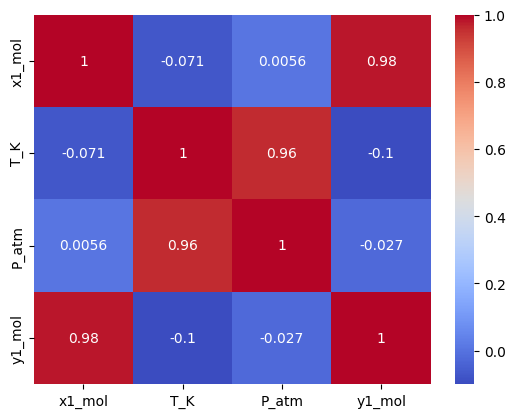

In [12]:
sns.heatmap(df.corr(), annot=True, cmap = "coolwarm")

# Scatter Plots

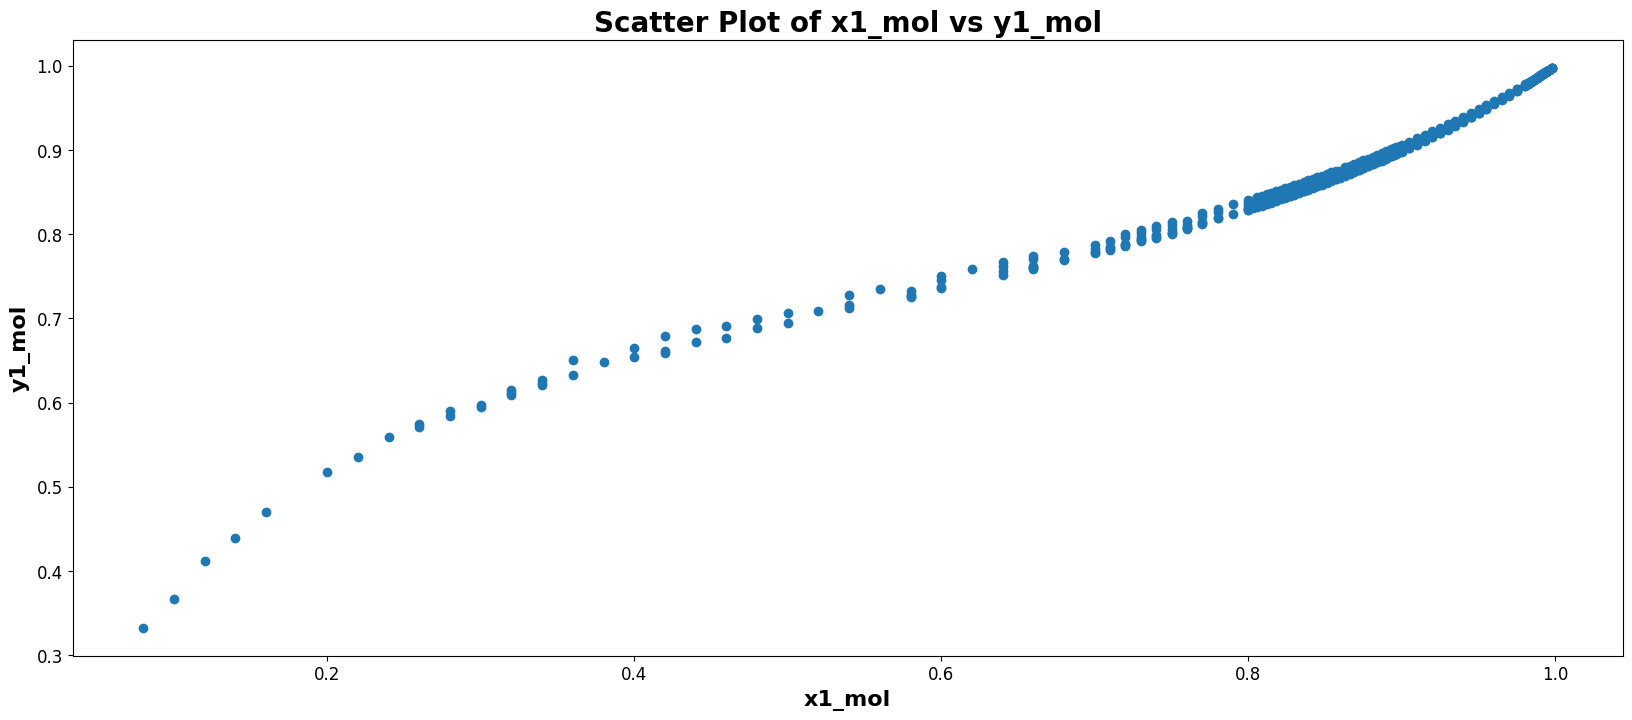

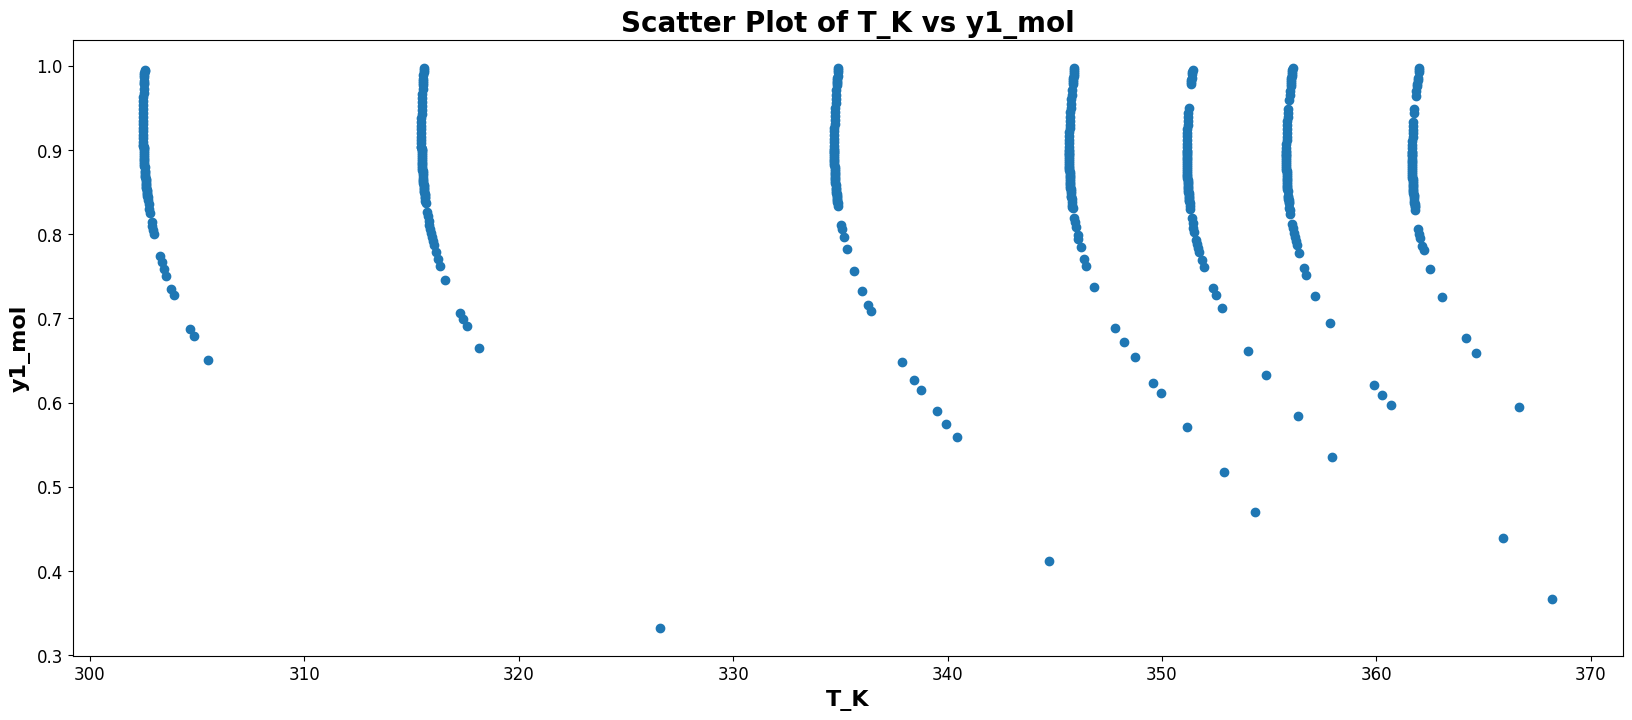

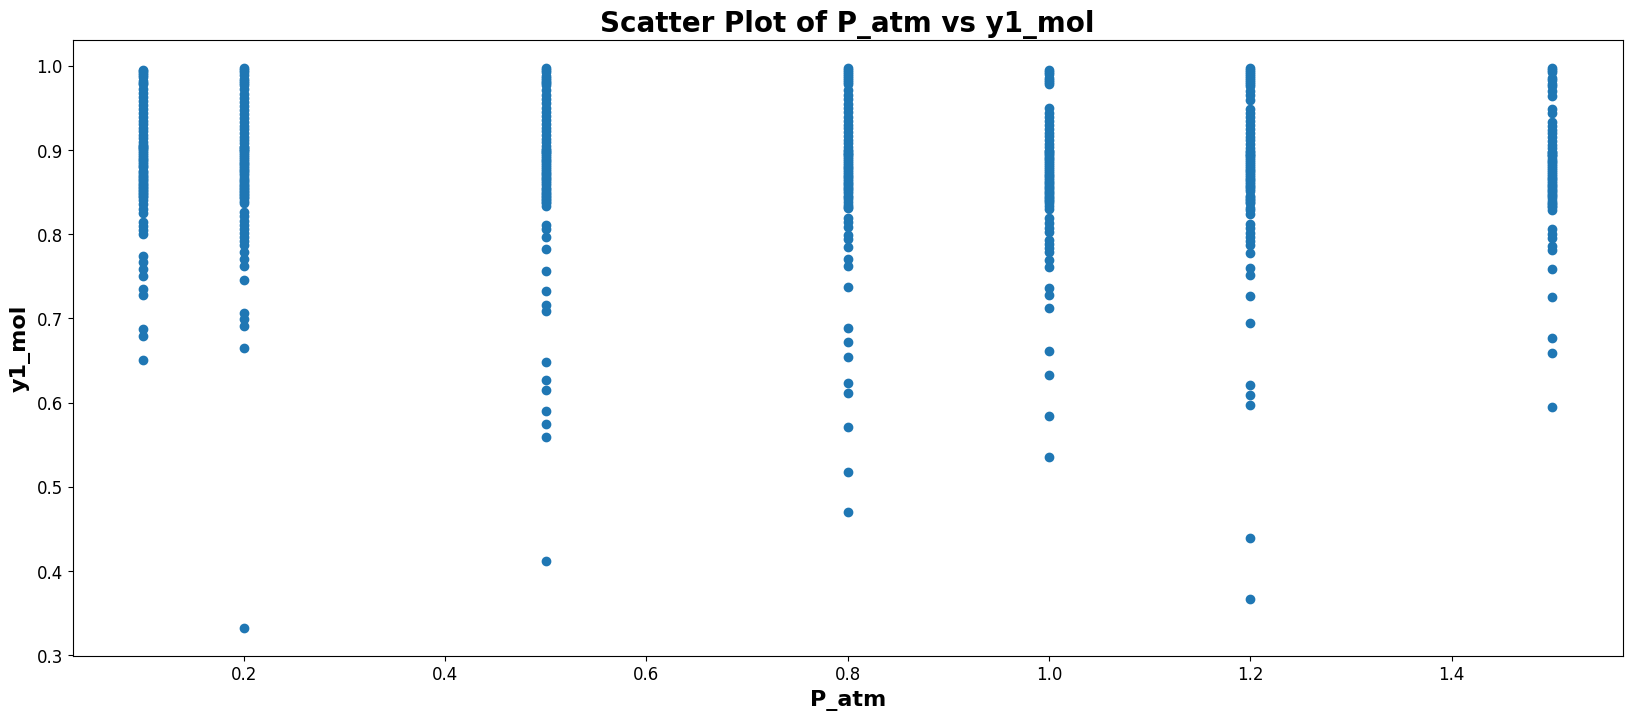

In [13]:
for column in df.drop(columns = "y1_mol").columns.tolist():
    plt.figure(figsize = (20, 8), dpi = 100, facecolor = "white", edgecolor = "black")
    scatter = plt.scatter(
        df[column], df["y1_mol"],
        marker = "o",
    )
    plt.title(f"Scatter Plot of {column} vs y1_mol", fontsize = 20, fontweight = "bold", color = "black", loc = "center")
    plt.xlabel(f"{column}", fontsize = 16, fontweight = "bold", color = "black")
    plt.ylabel("y1_mol", fontsize = 16, fontweight = "bold", color = "black")
    plt.xticks(rotation = 0, fontsize = 12)
    plt.yticks(rotation = 0, fontsize = 12)
    plt.show()

# Building ANN

In [14]:
# -------------------
# 1. Custom Transforms
# -------------------
class ToTensor:
    def __call__(self, sample):
        X, y = sample
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class Normalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    
    def __call__(self, sample):
        X, y = sample
        X = (X - self.mean) / self.std
        return X, y

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, sample):
        for t in self.transforms:
            sample = t(sample)
        return sample

In [15]:
# -------------------
# 2. Dataset
# -------------------
class CSVDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        df = pd.read_csv(csv_file)
        self.X = df.iloc[:, :-1].values.astype('float32')
        self.y = df.iloc[:, -1].values.astype('float32')
        self.transform = transform

        # Store mean/std for normalization
        self.mean = self.X.mean(axis=0)
        self.std = self.X.std(axis=0) + 1e-8   # avoid div by zero

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (self.X[idx], self.y[idx])
        if self.transform:
            sample = self.transform(sample)
        return sample


In [16]:
# -------------------
# 3. ANN Model
# -------------------
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=12):
        super(ANNModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [17]:
# -------------------
# 4. Training Function
# -------------------
def train(model, dataloader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        for X, y in dataloader:
            optimizer.zero_grad()
            outputs = model(X).squeeze()
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

In [18]:
def evaluate(model, dataloader, tol=0.05):
    model.eval()
    all_preds, all_targets, all_raoult, all_x1 = [], [], [], []

    # Example interaction parameter for Margules
    A = 1.0  # can be fitted later

    with torch.no_grad():
        for X, y in dataloader:
            preds = model(X).squeeze()

            X_np = X.numpy()
            x1 = X_np[:, 0]      # mole fraction ethanol
            T = X_np[:, 1]       # temperature
            P_total = X_np[:, 2] # total pressure

            x2 = 1 - x1

            # Margules activity coefficients
            gamma1 = np.exp(A * x2**2)
            gamma2 = np.exp(A * x1**2)

            # Activity-corrected Raoult's law
            raoult_preds = (x1 * gamma1 * P_total) / (x1 * gamma1 * P_total + x2 * gamma2 * P_total)

            # Store
            all_preds.extend(preds.tolist())
            all_targets.extend(y.tolist())
            all_raoult.extend(raoult_preds.tolist())
            all_x1.extend(x1.tolist())

    # Metrics for model
    mse = mean_squared_error(all_targets, all_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_preds)
    print(f"\nML Model Results: MSE={mse:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

    # Metrics for Raoult
    mse_r = mean_squared_error(all_targets, all_raoult)
    rmse_r = np.sqrt(mse_r)
    r2_r = r2_score(all_targets, all_raoult)
    print(f"Activity-Corrected Raoult's Law Results: MSE={mse_r:.4f}, RMSE={rmse_r:.4f}, R²={r2_r:.4f}")

    # Sample comparison
    print("\nSample Comparison (ML vs Raoult vs Actual):")
    for p, r, t in list(zip(all_preds, all_raoult, all_targets))[:10]:
        print(f"ML={p:.4f}, Raoult={r:.4f}, Actual={t:.4f}")

    # -------------------
    # Plot 1: Actual vs Predicted vs Raoult
    # -------------------
    plt.figure(figsize=(28,8))
    plt.plot(all_targets, label="Actual", marker='o')
    plt.plot(all_preds, label="ML Predicted", marker='x')
    plt.plot(all_raoult, label="Activity-Corrected Raoult", marker='s')
    plt.title("Actual vs Predicted vs Activity-Corrected Raoult's Law")
    plt.xlabel("Sample Index")
    plt.ylabel("y1 (Vapor mole fraction)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

    # -------------------
    # Plot 2: Predicted y vs x1_mol (mark points close enough)
    # -------------------
    plt.figure(figsize=(28,8))
    all_preds = np.array(all_preds)
    all_x1 = np.array(all_x1)

    # Mask of points where predicted y ≈ x1_mol
    mask = np.abs(all_preds - all_x1) <= tol

    plt.scatter(all_x1[mask], all_preds[mask], color='red', label=f'|y_pred - x1| ≤ {tol}', s=50)
    plt.plot([0,1], [0,1], color='gray', linestyle='--', label='y = x1')  # reference line
    plt.title("Predicted y vs x1_mol (Points where predicted ≈ x1) (Azeotropy)")
    plt.xlabel("x1_mol (Input)")
    plt.ylabel("Predicted y1")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()



In [19]:
def main(csv_file, batch_size=16, epochs=20, lr=0.001, train_split=0.8):
    raw_dataset = CSVDataset(csv_file)

    # Normalization transform
    transform = Compose([
        Normalize(mean=raw_dataset.mean, std=raw_dataset.std),
        ToTensor()
    ])

    dataset = CSVDataset(csv_file, transform=transform)

    # Train/Test split
    train_size = int(train_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_dim = dataset.X.shape[1]
    model = ANNModel(input_dim)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train
    train(model, train_loader, criterion, optimizer, epochs)

    # Evaluate
    evaluate(model, test_loader)

    return model

Epoch [1/50], Loss: 0.0163
Epoch [2/50], Loss: 0.0070
Epoch [3/50], Loss: 0.0037
Epoch [4/50], Loss: 0.0036
Epoch [5/50], Loss: 0.0098
Epoch [6/50], Loss: 0.0048
Epoch [7/50], Loss: 0.0036
Epoch [8/50], Loss: 0.0052
Epoch [9/50], Loss: 0.0105
Epoch [10/50], Loss: 0.0141
Epoch [11/50], Loss: 0.0065
Epoch [12/50], Loss: 0.0060
Epoch [13/50], Loss: 0.0039
Epoch [14/50], Loss: 0.0197
Epoch [15/50], Loss: 0.0060
Epoch [16/50], Loss: 0.0031
Epoch [17/50], Loss: 0.0157
Epoch [18/50], Loss: 0.0013
Epoch [19/50], Loss: 0.0042
Epoch [20/50], Loss: 0.0023
Epoch [21/50], Loss: 0.0091
Epoch [22/50], Loss: 0.0014
Epoch [23/50], Loss: 0.0017
Epoch [24/50], Loss: 0.0019
Epoch [25/50], Loss: 0.0015
Epoch [26/50], Loss: 0.0018
Epoch [27/50], Loss: 0.0049
Epoch [28/50], Loss: 0.0013
Epoch [29/50], Loss: 0.0018
Epoch [30/50], Loss: 0.0032
Epoch [31/50], Loss: 0.0020
Epoch [32/50], Loss: 0.0076
Epoch [33/50], Loss: 0.0011
Epoch [34/50], Loss: 0.0009
Epoch [35/50], Loss: 0.0006
Epoch [36/50], Loss: 0.0013
E

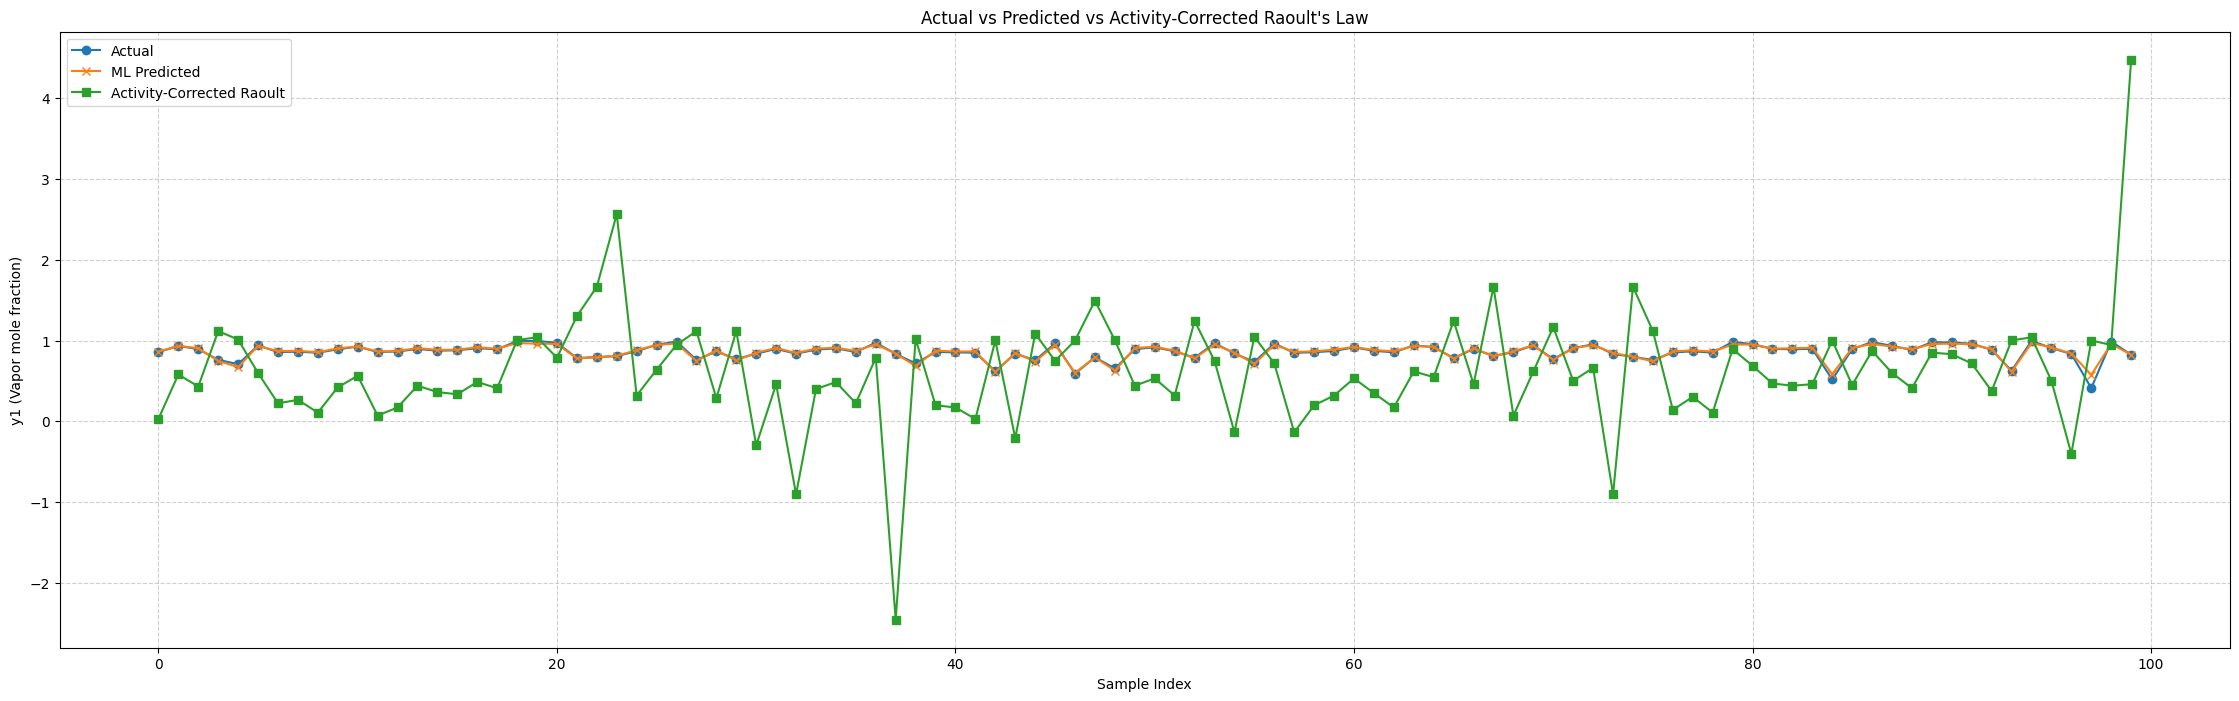

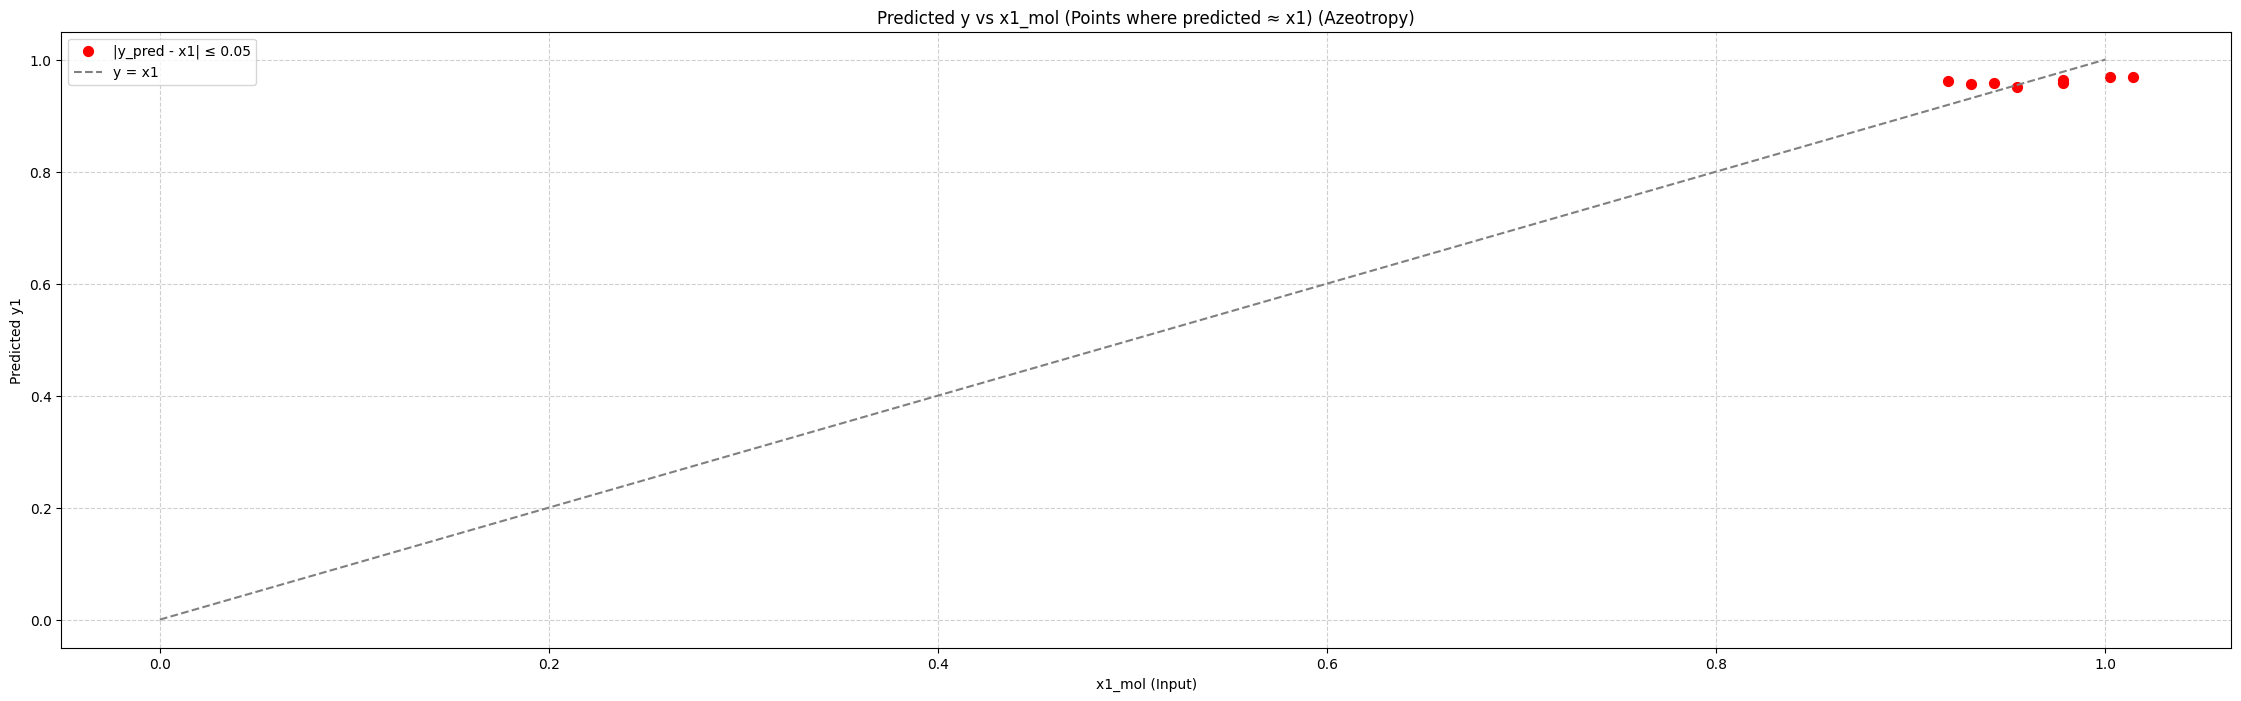

In [20]:
# -------------------
# Example Run
# -------------------
model = main("/kaggle/input/binary-azeotropic-vle-dataset/ethanol_water_vle_500.csv", batch_size=32, epochs=50, lr=0.001)

### Saving the model in onnx

In [21]:
dummy_input = torch.randn(1, 3)

# Export the model
onnx_file_path = "ann_model.onnx"
torch.onnx.export(
    model,               # your trained model
    dummy_input,         # example input
    onnx_file_path,      # output file
    export_params=True,  # store trained parameters
    opset_version=11,    # ONNX version
    do_constant_folding=True,  # optimize constants
    input_names=['x1_T_P'],    # input tensor name
    output_names=['y_pred'],   # output tensor name
    dynamic_axes={'x1_T_P': {0: 'batch_size'},  # allow variable batch size
                  'y_pred': {0: 'batch_size'}}
)

print(f"Model successfully exported to {onnx_file_path}")

Model successfully exported to ann_model.onnx
